In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2, l1_l2

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
train_df = train_df.fillna("NA")
test_df = test_df.fillna("NA")

In [4]:
train_df.head(n=3)

,id,keyword,location,text,target
0,1,NA,NA,Our Deeds are the Reason of this #earthquake M...,1
1,4,NA,NA,Forest fire near La Ronge Sask. Canada,1
2,5,NA,NA,All residents asked to 'shelter in place' are ...,1


In [5]:
train_texts = list(train_df['text'])
test_texts = list(test_df['text'])

targets = list(train_df['target'])

In [6]:
print(f"Number of tweets in train set : {len(train_df)}")
print(f"Number of tweets in test set : {len(test_df)}")
print()
print(f"Number of train tweets which have a target of 1: {len(train_df[train_df['target'] == 1])}")
print(f"Number of train tweets which have a target of 0: {len(train_df[train_df['target'] == 0])}")

Number of tweets in train set : 7613
Number of tweets in test set : 3263

Number of train tweets which have a target of 1: 3271
Number of train tweets which have a target of 0: 4342


#### There is no major class imbalance in train set. Tweets with target of '0' are 57% of total train set. Tweets with target of '1' are 43% of total train set.

In [7]:
for tweet in train_df['text'].head(5):
    print(tweet)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


#### The texts however are not clean. They contain special characters, quotes, commas etc. We need to clean the text before converting it to a sequence of integers. Following preprocessing functions will do the same.

## Preprocessing functions

In [45]:
import re
import string
from nltk.corpus import stopwords


def strip_and_lowercase(lines):
    """ Removing extra spaces at the end, beginning, or in the middle of a sentence """
    for i in range(len(lines)):
        lines[i] = lines[i].strip()
        lines[i] = ' '.join(lines[i].split())
        lines[i] = lines[i].lower()
    return lines


def expand_words(lines):
    """ Expanding words """
    expansion_dict = {"ain't": "are not", "'s": " is", "aren't": "are not", "don't": "do not",
                      "didn't": "did not", "won't": "will not",
                      "can't": "cannot"}
    
    for i in range(len(lines)):
        words = lines[i].split()
        for j in range(len(words)):
            if words[j] in expansion_dict:
                words[j] = expansion_dict[words[j]]
        lines[i] = ' '.join(words)
    return lines


def remove_punctuations(lines):
    """ Removing punctuations """
    for i in range(len(lines)):
        lines[i] = lines[i].translate(str.maketrans('', '', string.punctuation))
    return lines
    
    
def remove_stopwords(lines):
    """ Removing stopwords """
    stop_words = set(stopwords.words('english'))
    
    for i in range(len(lines)):
        lines[i] = " ".join([word for word in lines[i].split() if word not in stop_words])
    return lines


def remove_special_chars(lines):
    """ Removing special characters """
    for i in range(len(lines)):
        lines[i] = re.sub('[-+.^:,]', '', lines[i])
    return lines


def remove_emojis(lines):
    """ Removing emojis """
    emojis = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002500-\U00002BEF"  # chinese char
                        u"\U00002702-\U000027B0"
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\U00010000-\U0010ffff"
                        u"\u2640-\u2642"
                        u"\u2600-\u2B55"
                        u"\u200d"
                        u"\u23cf"
                        u"\u23e9"
                        u"\u231a"
                        u"\ufe0f"  # dingbats
                        u"\u3030"
                        "]+", re.UNICODE)
    
    for i in range(len(lines)):
        lines[i] = re.sub(emojis, '', lines[i])
    return lines

In [46]:
def preprocess(texts):
    texts = strip_and_lowercase(texts)
    texts = expand_words(texts)
    texts = remove_punctuations(texts)
    texts = remove_stopwords(texts)
    texts = remove_special_chars(texts)
    texts = remove_emojis(texts)
    return texts

In [47]:
# Clean train and text tweets
train_texts = preprocess(train_texts)
test_texts = preprocess(test_texts)

In [48]:
TOP_K = 2000
MAX_SEQUENCE_LENGTH = max(len(max(train_texts, key=len)), len(max(test_texts, key=len)))
batch_size = 256

### Converting texts to sequence of integers using keras tokenizer

In [49]:
tokenizer = Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(train_texts)
X = tokenizer.texts_to_sequences(train_texts)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = np.array(targets)

In [50]:
# splitting data into train and test

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

In [51]:
# Function to create a tf data object

def input_fn(X: np.ndarray, y: np.ndarray, batch_size: int,  mode: str = 'eval'):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=batch_size)
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.prefetch(buffer_size=batch_size)
    return dataset

In [52]:
train_dataset = input_fn(X=X_train, y=y_train, batch_size=batch_size, mode='train')
val_dataset = input_fn(X=X_val, y=y_val, batch_size=batch_size, mode='eval')

In [53]:
num_features = min(len(tokenizer.word_index) + 1, TOP_K)

In [54]:
cp_callback = ModelCheckpoint(filepath='disaster_tweet_classification.hdf5',
                                          monitor='val_accuracy',
                                          save_freq='epoch', verbose=1, period=1,
                                          save_best_only=True, save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               verbose=1, patience=5)

### We will use a hybrid model which has both convolution and LSTM layers

In [55]:
def build_hybrid_model():
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(MAX_SEQUENCE_LENGTH,), name="input"))
    model.add(layers.Embedding(input_dim=num_features,
                               output_dim=150,
                               input_length=MAX_SEQUENCE_LENGTH))
    model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(64, recurrent_dropout=0.5, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=["accuracy"])
    return model

In [56]:
model = build_hybrid_model()
steps_per_epoch = int(y_train.size / batch_size)*1.5
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=[cp_callback, early_stopping])

Epoch 1/10
39/39 [==============================] - 11s 237ms/step - loss: 2.3976 - accuracy: 0.5711 - val_loss: 1.8712 - val_accuracy: 0.5748

Epoch 00001: val_accuracy improved from -inf to 0.57480, saving model to disaster_tweet_classification.hdf5
Epoch 2/10
39/39 [==============================] - 9s 237ms/step - loss: 1.5730 - accuracy: 0.6659 - val_loss: 1.3084 - val_accuracy: 0.7992

Epoch 00002: val_accuracy improved from 0.57480 to 0.79921, saving model to disaster_tweet_classification.hdf5
Epoch 3/10
39/39 [==============================] - 9s 237ms/step - loss: 1.1365 - accuracy: 0.8256 - val_loss: 1.0941 - val_accuracy: 0.8084

Epoch 00003: val_accuracy improved from 0.79921 to 0.80840, saving model to disaster_tweet_classification.hdf5
Epoch 4/10
39/39 [==============================] - 9s 237ms/step - loss: 0.9590 - accuracy: 0.8528 - val_loss: 1.0061 - val_accuracy: 0.8110

Epoch 00004: val_accuracy improved from 0.80840 to 0.81102, saving model to disaster_tweet_classi

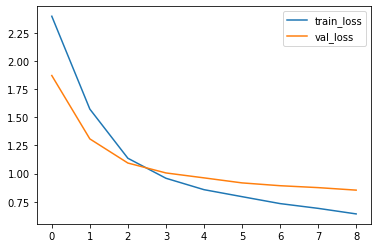

In [57]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

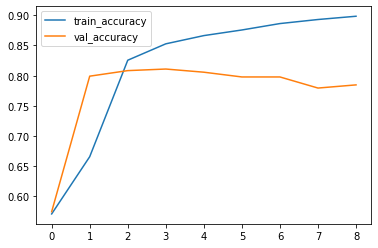

In [58]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [59]:
model = build_hybrid_model()
model.load_weights('disaster_tweet_classification.hdf5')

In [60]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [61]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [62]:
lines = tokenizer.texts_to_sequences(test_texts)
lines = sequence.pad_sequences(lines, maxlen=MAX_SEQUENCE_LENGTH)

In [63]:
def predict(review: np.ndarray):
    result = model.predict(np.array([review]))
    result = result[0][0]
    if result > 0.5:
        return 1
    else:
        return 0

In [64]:
result_dict = {'id': list(test_df['id']), 'target': []}

In [65]:
for line in tqdm(lines, desc="Predicting"):
    result_dict['target'].append(predict(line))

Predicting: 100%|██████████| 3263/3263 [02:47<00:00, 19.52it/s]


In [66]:
result_df = pd.DataFrame(result_dict)

In [67]:
result_df.head(n=5)

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [69]:
result_df.to_csv('submission.csv', index=False)